# [COM6513] Assignment 1: Sentiment Analysis with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test a **text classification** system for **sentiment analysis**, in particular to predict the sentiment of movie reviews, i.e. positive or negative (binary classification).



For that purpose, you will implement:


- Text processing methods for extracting Bag-Of-Word features, using 
    - n-grams (BOW), i.e. unigrams, bigrams and trigrams to obtain vector representations of documents where n=1,2,3 respectively. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). 
    - character n-grams (BOCN). A character n-gram is a contiguous sequence of characters given a word, e.g. for n=2, 'coffee' is split into {'co', 'of', 'ff', 'fe', 'ee'}. Two vector weighting schemes should be tested: (1) raw frequencies (**1 mark**); (2) tf.idf (**1 mark**). **Tip: Note the large vocabulary size!** 
    - a combination of the two vector spaces (n-grams and character n-grams) choosing your best performing wighting respectively (i.e. raw or tfidf). (**1 mark**) **Tip: you should merge the two representations**



- Binary Logistic Regression (LR) classifiers that will be able to accurately classify movie reviews trained with: 
    - (1) BOW-count (raw frequencies) 
    - (2) BOW-tfidf (tf.idf weighted)
    - (3) BOCN-count
    - (4) BOCN-tfidf
    - (5) BOW+BOCN (best performing weighting; raw or tfidf)



- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function (**1 mark**)
    - Use L2 regularisation (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous development loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)



- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength) for each LR model? You should use a table showing model performance using different set of hyperparameter values. (**2 marks). **Tip: Instead of using all possible combinations, you could perform a random sampling of combinations.**


- After training each LR model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot. Does your model underfit, overfit or is it about right? Explain why. (**1 mark**). 


- Identify and show the most important features (model interpretability) for each class (i.e. top-10 most positive and top-10 negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!). If you were to apply the classifier into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 


- Provide efficient solutions by using Numpy arrays when possible (you can find tips in Lab 1 sheet). Executing the whole notebook with your code should not take more than 5 minutes on a any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs (**2 marks**). 






### Data 

The data you will use are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.




### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex` or you can print it as PDF using your browser).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 14 Mar 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

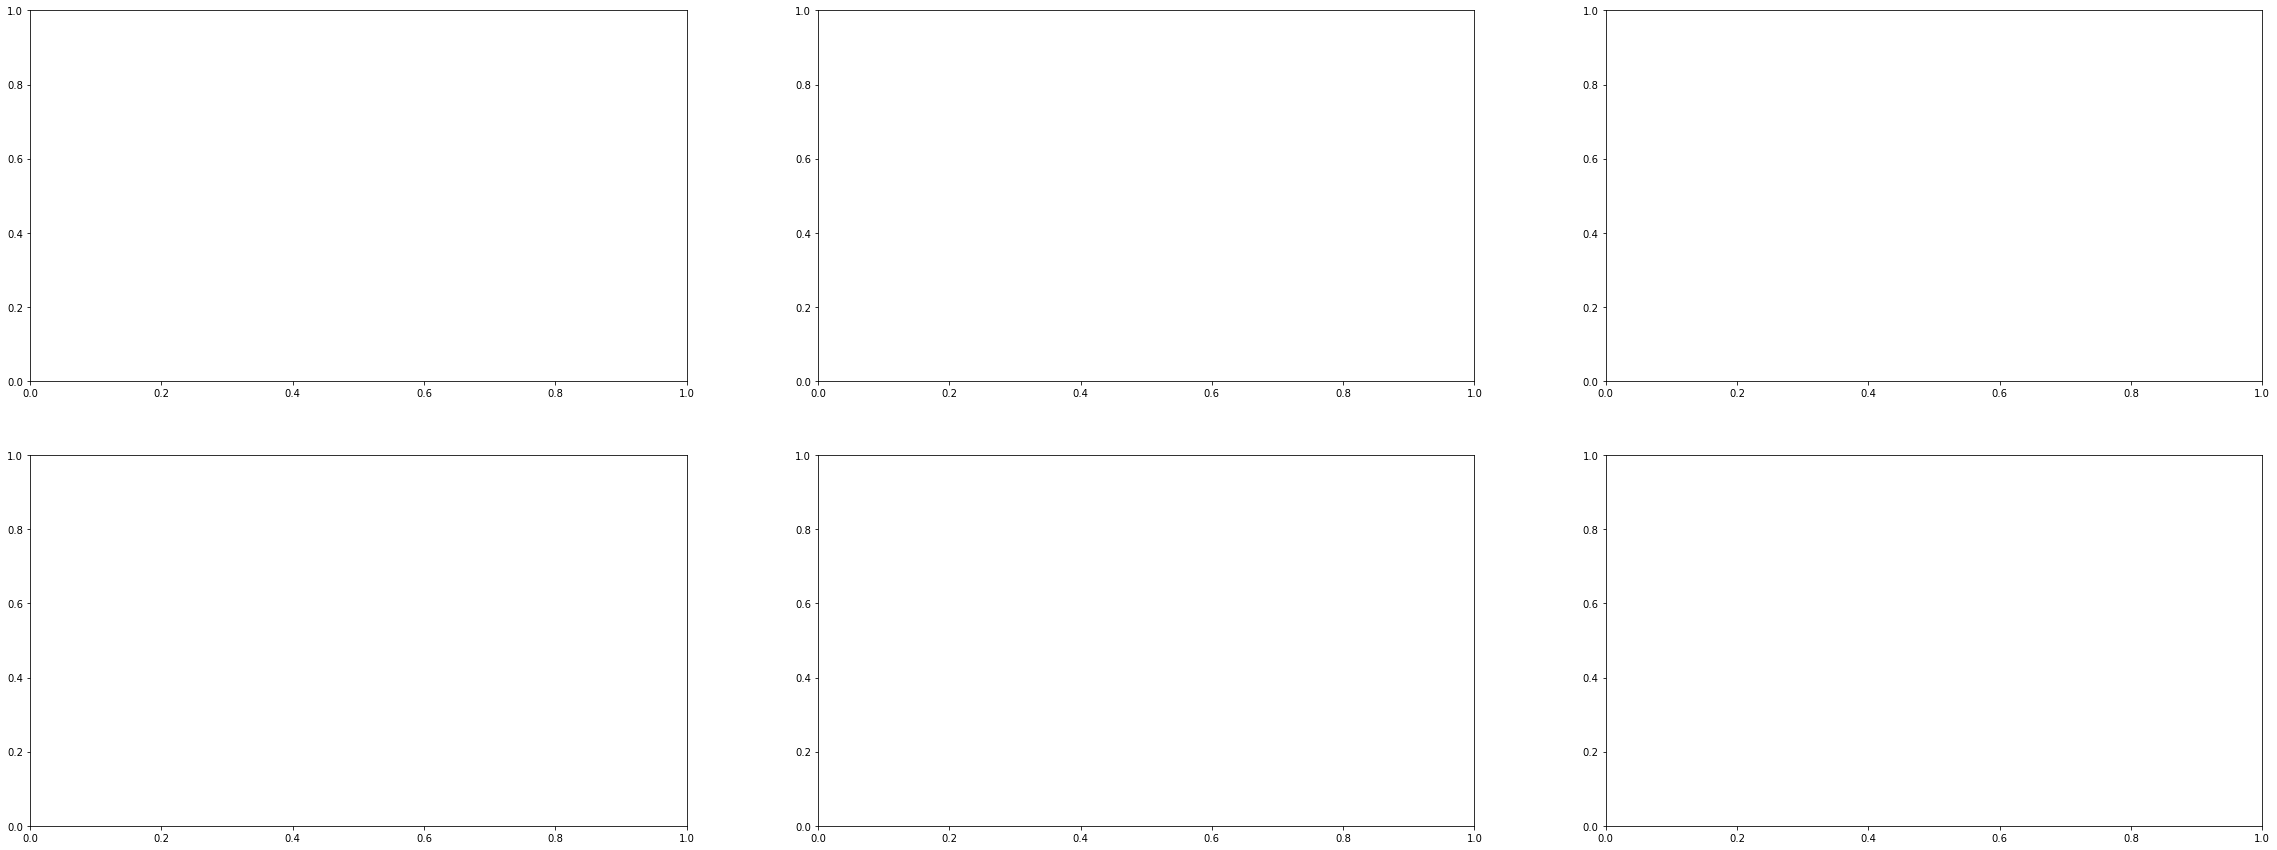

In [19]:
def plot_learning_process(ax, tl, vl):
    ax.plot(range(len(tl)), tl, label = 'training_losses')
    ax.plot(range(len(vl)), vl, label = 'validation_losses')
    ax.legend()
    ax.set_title("Training and validation loss V/S epoch")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    
tl = [[1,2,3], [4,5,6]]
vl = [[3,2,1], [6,5,4]]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (40,15))

# for ax,i,j in zip(axes.flatten(),tl, vl):
# plot_learning_process(ax[1,2], i, j )
    
# plt.subplots_adjust(bottom=0.006, right=0.8, top=0.09)

In [6]:
train_data = pd.read_csv("data_sentiment/train.csv", header=None)
val_data = pd.read_csv("data_sentiment/dev.csv", header=None)
test_data = pd.read_csv("data_sentiment/test.csv", header=None)

If you use Pandas you can see a sample of the data.

In [7]:
train_data.sample(10)

,0,1
952,you know that a movie has issues when most eve...,0
908,"while watching loser , it occurred to me that ...",0
221,"richard gere can be a commanding actor , but h...",1
310,"though it is a fine piece of filmmaking , ther...",1
218,if there is one thing that bothers me about ho...,1
188,""" when it's cold , molecules aren't moving . ...",1
961,when walt disney pictures announced a live-act...,0
252,( note : there are spoilers regarding the fil...,1
1046,i love movies . i really do . every time i w...,0
18,note : some may consider portions of the follo...,1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [8]:
train_raw_texts = train_data[0].tolist()
train_labels = train_data[1].to_numpy()

val_raw_texts = val_data[0].tolist()
val_labels = val_data[1].to_numpy()

test_raw_texts = test_data[0].tolist()
test_labels = test_data[1].to_numpy()

# Vector Representations of Text 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams (or character ngrams from the unigrams)
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (or character n-grams). You can keep top N if you encounter memory issues.


In [9]:
# A few more words have been added in the given list
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its', 's',
              'about', 'above', 'after', 'again', 'all', 'also', 'am', 'any', "aren", "t", 
               'because', 'before', 'being', 'below', 'between', 'both', 'but', 'cannot', 
               'does', 'down', 'during', 'each', 'don', 'doing'
               'else', 'ever', 'few', 'further', 'get', 'had', 'having',
               "d", "ll", 'here', 'hers', 'herself', 'him', 'himself', 'how', 
               'however', "m", "ve", 'if', 'into', "isn", 'itself', 'just',
               "let", 'me', 'more', 'most', "mustn", 'my', 'myself', 'no', 'nor', 'not', 'off', 
               'once', 'only', 'other', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 
               'same', 'shall', "shan", 'should', "shouldn",'since', 'so', 
               'some', 'such', 'than', 'their', 'theirs', 'themselves', 'then', 'there', "couldn", 'doesn', 'hadn', 'haven' 
                "re", 'through', 'too', 'under', 'until', 'up', 'very', 
               "wasn", "weren", 'when', 'where',
               'while', 'whom', 'why', "won", 'would', "wouldn", 
               'your', 'yours', 'yourself', 'yourselves', '']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `char_ngrams`: boolean. If true the function extracts character n-grams

and returns:

- `x': a list of all extracted features.

See the examples below to see how this function should work.

In [10]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'[^A-Za-z]+', 
                   stop_words=[], vocab=set(), char_ngrams=False):        
    x = []
    if char_ngrams:
        xraw = re.sub('[^A-Za-z0-9]+', '', x_raw)
        for n in range(ngram_range[0], ngram_range[1]+1):
            for i in range(len(xraw)-n+1):
                ngram = xraw[i:i+n] 
                x.append(ngram)
        
    else:
        tokenize = re.compile(token_pattern)
        words = tokenize.split(x_raw)
        
        # Use vocab only if its not empty
        if len(vocab) != 0:
            uni_gram = [word for word in words if word not in stop_words and word in vocab]
        else:
            uni_gram = [word for word in words if word not in stop_words]
            
        # Getting n-grams 
        for n in range(ngram_range[0], ngram_range[1]+1):    
            if n == 1:
                x = x + uni_gram   
            else:
                for i in range(len(uni_gram)-n+1):
                    ngram = tuple(uni_gram[i:i+n])
                    x.append(ngram)
    
    return x

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

For extracting character n-grams the function should work as follows:

In [11]:
char_ngram = extract_ngrams("movie", 
               ngram_range=(1,3), 
               stop_words=[],
               char_ngrams=True)

char_ngram

['m', 'o', 'v', 'i', 'e', 'mo', 'ov', 'vi', 'ie', 'mov', 'ovi', 'vie']

### Create a vocabulary 

The `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [12]:
%%time 
def get_doc_freq(ngram, doc_freq):
    
    unique_ngrams = dict.fromkeys(ngram) # To get unique ngrams from the given ngrams
    for term in unique_ngrams:
        if term in doc_freq:     # If the ngram already exist in the dict, the document frequency is increased by 1
            doc_freq[term] += 1
        else:
            doc_freq[term] = 1   # Else add the ngram in the dict
    
    return doc_freq

def get_ngrams_counts(ngram, counts):
    for term in ngram:
        if term in counts:
            counts[term] += 1
        else:
            counts[term] = 1
            
    return counts


def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r' ', 
              min_df=0, keep_topN=0, 
              stop_words=[],char_ngrams=False):
    
    df = {}
    ngram_counts = {}
    for text in X_raw:
        text_ngrams = extract_ngrams(text,
                       ngram_range=ngram_range,
                       stop_words=stop_words,
                       char_ngrams=char_ngrams)
        
        ngram_counts = get_ngrams_counts(text_ngrams, ngram_counts)
        df = get_doc_freq(text_ngrams, df)
        
    df = { k:v for k,v in df.items() if v > min_df}
    ngram_counts = dict(sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:keep_topN])
    
    vocab = ngram_counts.keys() & df.keys() 
    
    return vocab, df, ngram_counts

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 10 µs


Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [13]:
%%time
# for BOW
vocab,doc_freq,ngram_count = get_vocab(train_raw_texts,
                                       ngram_range=(1,2),
                                       min_df = 100,
                                      keep_topN = 10000,
                                      stop_words = stop_words)

CPU times: user 1.89 s, sys: 38.6 ms, total: 1.93 s
Wall time: 1.93 s


In [14]:
%%time
# for BOCN
vocab_ch,doc_freq_ch,ngram_count_ch = get_vocab(train_raw_texts,
                                       ngram_range=(1,2),
                                       min_df = 100,
                                      keep_topN = 10000,
                                      stop_words = stop_words,
                                      char_ngrams = True)

CPU times: user 2.29 s, sys: 6.55 ms, total: 2.3 s
Wall time: 2.3 s


Then, you need to create 2 dictionaries: (1) vocabulary id -> word; and  (2) word -> vocabulary id so you can use them for reference:

In [15]:
vocab_id2word = dict(enumerate(vocab))
vocab_word2id = dict((v,k) for k,v in vocab_id2word.items())

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [16]:
%%time
def convert_into_ngrams(raw_texts, ch_ngram, vocab):
    text_ngram_list = []
    for text in raw_texts:
        text_ngram = extract_ngrams(text, 
                                    ngram_range = (1,3),
                                    stop_words = stop_words,
                                    vocab = vocab,
                                    char_ngrams = ch_ngram)
        text_ngram_list.append(text_ngram)
    return text_ngram_list

#BOW
train_ngrams = convert_into_ngrams(train_raw_texts, False, vocab = vocab)
val_ngrams = convert_into_ngrams(val_raw_texts, False, vocab = vocab)
test_ngrams = convert_into_ngrams(test_raw_texts, False, vocab = vocab)


#BOCN
train_ch_ngrams = convert_into_ngrams(train_raw_texts, True, vocab = vocab_ch)
val_ch_ngrams = convert_into_ngrams(val_raw_texts, True, vocab = vocab_ch)
test_ch_ngrams = convert_into_ngrams(test_raw_texts, True, vocab = vocab_ch)

CPU times: user 4.62 s, sys: 245 ms, total: 4.87 s
Wall time: 4.9 s


## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [17]:
%%time
def vectorise(X_ngram, vocab):
    
    X_vec = []
    
    for ngram in X_ngram:
        row = []
        for term in vocab:
            row.append(ngram.count(term))
        X_vec.append(row)
    
    X_vec = np.array(X_vec)
    return X_vec

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [18]:
%%time
# for BOW
train_count_vector = vectorise(train_ngrams, vocab)
val_count_vector = vectorise(val_ngrams, vocab)
test_count_vector = vectorise(test_ngrams, vocab)

CPU times: user 8.54 s, sys: 45.4 ms, total: 8.59 s
Wall time: 8.6 s


In [19]:
%%time
# for BOCN
train_ch_count_vector = vectorise(train_ch_ngrams, vocab_ch)
val_ch_count_vector = vectorise(val_ch_ngrams, vocab_ch)
test_ch_count_vector = vectorise(test_ch_ngrams, vocab_ch)

CPU times: user 1min 47s, sys: 229 ms, total: 1min 48s
Wall time: 1min 48s


#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [20]:
%%time
import math
def get_idfs(corpus, vocab, df):
    
    N = len(corpus)
    term_idfs = []
    for term in vocab:
        idf = math.log10(N/df[term])
        term_idfs.append(idf)
    
    return term_idfs

# for BOW
train_term_idfs = get_idfs(train_count_vector, vocab, doc_freq)
train_term_idfs = np.asarray(train_term_idfs)

# for BOCN
train_ch_term_idfs = get_idfs(train_ch_count_vector, vocab_ch, doc_freq_ch)
train_ch_term_idfs = np.asarray(train_ch_term_idfs)

CPU times: user 327 µs, sys: 17 µs, total: 344 µs
Wall time: 347 µs


Then transform your count vectors to tf.idf vectors:

In [21]:
def get_tfidf_vector(dataset, term_idfs):
    
    new_vec = []
    for row in dataset:
        row = np.multiply(row, term_idfs)
        new_vec.append(row)
    return np.array(new_vec)

In [22]:
train_tfidf_vector = get_tfidf_vector(train_count_vector, train_term_idfs)
val_tfidf_vector = get_tfidf_vector(val_count_vector, train_term_idfs)
test_tfidf_vector = get_tfidf_vector(test_count_vector, train_term_idfs)

In [23]:
%%time
train_ch_tfidf_vector = get_tfidf_vector(train_ch_count_vector, train_ch_term_idfs)
val_ch_tfidf_vector = get_tfidf_vector(val_ch_count_vector, train_ch_term_idfs)
test_ch_tfidf_vector = get_tfidf_vector(test_ch_count_vector, train_ch_term_idfs)

CPU times: user 5.34 ms, sys: 2.78 ms, total: 8.11 ms
Wall time: 7.36 ms


# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [24]:
def sigmoid(z):
    
    sig = 1.0 / (1 + np.exp(-z))
    return sig

Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [25]:
def predict_proba(X, weights):
    
    z = np.dot(X, weights.T)
    preds_proba = sigmoid(z)
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [26]:
def predict_class(X, weights):
    
    preds_class = predict_proba(X, weights)
    preds_class = np.where(preds_class < 0.5, 0, 1)
    
    return preds_class


To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [27]:
def binary_loss(X, Y, weights, alpha=0.00001):
    
    prob_y = predict_proba(X, weights)
    loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
    loss_reg = np.mean(alpha*np.dot(weights.T, weights))
    l = loss + loss_reg
    
    return l

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [28]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.1, 
        alpha=0.00001, epochs=5, 
        tolerance=0.0001, print_progress=True):
    
    tr_docs, tr_features = X_tr.shape
    dv_docs, dv_features = X_dev.shape
    
    weights = np.zeros((1,tr_features))  # initialise weights as zero
    
    y_tr = Y_tr.reshape((tr_docs,1))
    y_dev = Y_dev.reshape((dv_docs,1))
    
    training_loss_history = []
    validation_loss_history = []
    
    for epoch in range(epochs):
        p = np.random.permutation(len(y_tr))  # Step1: randomising the training data
        x_new = X_tr[p]
        y_new = y_tr[p]
        
        for i in range(len(x_new)):
            y_pred = predict_proba(x_new[i], weights)  
            grad = (x_new[i] * (y_pred - y_new[i])) + (alpha * weights)  # Step2: calculating gradient
            weights = weights - (lr * grad)  # Step3: update weights
            
        loss_tr = binary_loss(x_new, y_new, weights, alpha)
        loss_dev = binary_loss(X_dev, y_dev, weights, alpha)
        
        if print_progress:
            print("Training_loss : " + str(loss_tr))
            print("Validation_loss : " + str(loss_dev))
            
        training_loss_history.append(loss_tr)       # Step4: Keeping track of the losses
        validation_loss_history.append(loss_dev)
        
        
        if epoch > 0 and (validation_loss_history[epoch-1] - validation_loss_history[epoch]) < tolerance:  # Step5: Checking if the loss is less than tolerance
            break
    
        
    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [29]:
%%time
w, t, v = SGD(train_count_vector, train_labels, val_count_vector, val_labels, print_progress = False)

CPU times: user 573 ms, sys: 162 ms, total: 734 ms
Wall time: 133 ms


<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))


In [38]:
# Hyperparameter tuning
# The hyperparameters tuned below are - regularisation strength(alpha) and learning_rate(lr)

def hyperparameter_tuning(train_set, train_label, val_set, val_label, epochs):
    alpha_opts = np.logspace(start = -6, stop = -1, num = 5)
    lr_opts = np.logspace(start = -4, stop = 0, num = 5)

    loss_history = []
    min_loss = 9999999

    best_alpha = 0
    best_lr = 0
    
    for alpha in alpha_opts:
        for lr in lr_opts:
            w, t, v = SGD(train_count_vector, train_labels, val_count_vector, val_labels, lr = lr, alpha = alpha, epochs = epochs, print_progress = False)
            loss = binary_loss(val_count_vector, val_labels, w, alpha)
            loss_history.append(loss)
            if loss < min_loss: 
                min_loss = loss
                best_alpha = alpha
                best_lr = lr 
            
    print("best params: " + str(best_alpha) + str(best_lr))
    
    return best_lr, best_alpha

In [31]:
best_lr, best_alpha = hyperparameter_tuning(train_count_vector, train_labels, val_count_vector, val_labels, 1000)

<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-24-ce952f6fbf7d>:3: RuntimeWarning: overflow encountered in exp
  sig = 1.0 / (1 + np.exp(-z))


best params: 0.10.0001


Now plot the training and validation history per epoch for the best hyperparameter combination. Does your model underfit, overfit or is it about right? Explain why.

In [32]:
%%time
w_counts, tl_counts, vl_counts = SGD(train_count_vector, train_labels, 
                                     val_count_vector, val_labels, 
                                     lr = best_lr, alpha = best_alpha, 
                                     epochs = 100, 
                                     print_progress = False)

CPU times: user 4.78 s, sys: 1.07 s, total: 5.85 s
Wall time: 789 ms


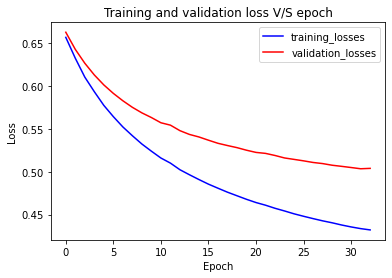

In [34]:
def plot_learning_process(tl, vl):
    plt.plot(range(len(tl)), tl, 'b', label = 'training_losses')
    plt.plot(range(len(vl)), vl, 'r', label = 'validation_losses')
    plt.legend()
    plt.title("Training and validation loss V/S epoch")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
plot_learning_process(tl_counts, vl_counts)

#### Answer
As is evident from the plot shown above, the losses for both training and validation sets are decreasing with increasing epochs. The performance is approximately similar for training and evaluation phase. Hence, we can say that the model fits approximately right.

#### Evaluation

Compute accuracy, precision, recall and F1-scores:

In [41]:
def train_and_evaluate(train_set, train_labels, val_set, val_labels, test_set, test_labels, best_lr, best_alpha, epochs ):
    w, t, v = SGD(train_set, train_labels, 
                                     val_set, val_labels, 
                                     lr = best_lr, alpha = best_alpha, 
                                     epochs = epochs, 
                                     print_progress = False)

    preds_te = predict_class(test_set, w)

    print('Accuracy:', accuracy_score(test_labels,preds_te))
    print('Precision:', precision_score(test_labels,preds_te))
    print('Recall:', recall_score(test_labels,preds_te))
    print('F1-Score:', f1_score(test_labels,preds_te))
    
    return w, t, v

In [42]:
%%time
w, t, v = train_and_evaluate(train_count_vector, train_labels, val_count_vector, val_labels, test_count_vector, test_labels, best_lr, best_alpha, 100)

Accuracy: 0.8075
Precision: 0.783410138248848
Recall: 0.85
F1-Score: 0.815347721822542
CPU times: user 5.45 s, sys: 1.41 s, total: 6.86 s
Wall time: 951 ms


Finally, print the top-10 words for the negative and positive class respectively.

In [43]:
# top 10 negative words
top_neg = w_counts[0].argsort()[:10]
for i in top_neg:
    print(vocab_id2word[i])

bad
even
plot
worst
script
nothing
boring
better
unfortunately
supposed


In [44]:
# top 10 positive words
top_pos = w_counts[0].argsort()[::-1][:10] # Taking the last elements as the array is sorted in ascending order
for i in top_pos:
    print(vocab_id2word[i])

great
well
life
world
many
best
quite
seen
movies
american


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

#### Answer
I think the features could generalise well in another domain if trained thoroughly. It has some generalise terms like bad, worst, unfortunately for negative class and some general positive words like great, well, fun. 

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

#### Answer

The best hyperparameters for the model are selected using the "Grid Search" algorithm for hyperparameter tuning. The implementation is done from scratch and no additional library is used. 

Learning rate measures how rapidly the gradient converges to its minimum. Hence, higher learning rate implies that the model will take less epochs to reach to its optimum point and so we can say that learning rate and epochs have an inverse relationship. Regularisation strength ensures that the model does not overfit the training data. So it makes sure that the weights are not adjusted too much. It does not directly affects the training performance of the model but it will make the model more generalize thus, ensuring higher evaluation and testing accuracy.

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


### Now repeat the training and evaluation process for BOW-tfidf, BOCN-count, BOCN-tfidf, BOW+BOCN including hyperparameter tuning for each model...

In [45]:
# BOW-tfidf
best_lr, best_alpha = hyperparameter_tuning(train_tfidf_vector, train_labels, val_tfidf_vector, val_labels, 1000)

<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-24-ce952f6fbf7d>:3: RuntimeWarning: overflow encountered in exp
  sig = 1.0 / (1 + np.exp(-z))


best params: 0.10.0001


Accuracy: 0.835
Precision: 0.8018018018018018
Recall: 0.89
F1-Score: 0.8436018957345972
CPU times: user 12.8 s, sys: 3.28 s, total: 16.1 s
Wall time: 2.23 s


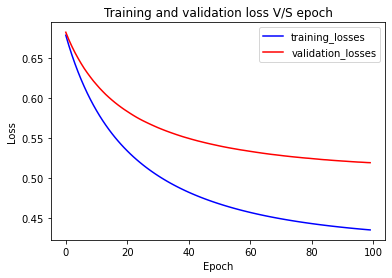

In [46]:
%%time
w, t, v = train_and_evaluate(train_tfidf_vector, train_labels, val_tfidf_vector, val_labels, test_tfidf_vector, test_labels, best_lr, best_alpha, 100)
plot_learning_process(t, v)

In [47]:
# BOCN-tfidf
best_lr, best_alpha = hyperparameter_tuning(train_ch_tfidf_vector, train_labels, val_ch_tfidf_vector, val_labels, 500)

<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-24-ce952f6fbf7d>:3: RuntimeWarning: overflow encountered in exp
  sig = 1.0 / (1 + np.exp(-z))


best params: 0.10.0001


Accuracy: 0.6175
Precision: 0.6
Recall: 0.705
F1-Score: 0.6482758620689655
CPU times: user 10.5 s, sys: 3.05 s, total: 13.6 s
Wall time: 1.94 s


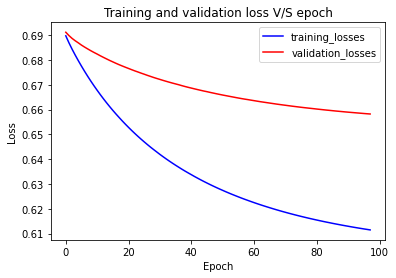

In [48]:
%%time
w, t, v = train_and_evaluate(train_ch_tfidf_vector, train_labels, val_ch_tfidf_vector, val_labels, test_ch_tfidf_vector, test_labels, best_lr, best_alpha, 100)
plot_learning_process(t, v)

In [49]:
# BOCN-count
best_lr, best_alpha = hyperparameter_tuning(train_ch_count_vector, train_labels, val_ch_count_vector, val_labels, 500)

<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-24-ce952f6fbf7d>:3: RuntimeWarning: overflow encountered in exp
  sig = 1.0 / (1 + np.exp(-z))


best params: 0.10.0001


<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))


Accuracy: 0.61
Precision: 0.5635838150289018
Recall: 0.975
F1-Score: 0.7142857142857143
CPU times: user 13 s, sys: 3.16 s, total: 16.2 s
Wall time: 2.15 s


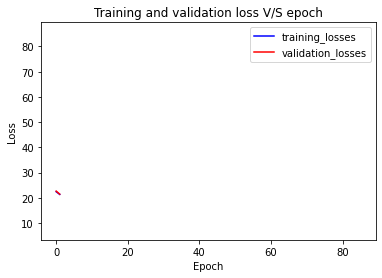

In [81]:
%%time
w, t, v = train_and_evaluate(train_ch_count_vector, train_labels, val_ch_count_vector, val_labels, test_ch_count_vector, test_labels, best_lr, best_alpha, 100)
plot_learning_process(t, v)

In [82]:
# BOCN + BOW
train_data = np.hstack((train_tfidf_vector, train_ch_tfidf_vector))   # Combining the two representations
val_data = np.hstack((val_tfidf_vector, val_ch_tfidf_vector))
test_data = np.hstack((test_tfidf_vector, test_ch_tfidf_vector))

best_lr, best_alpha = hyperparameter_tuning(train_data, train_labels, val_data, val_labels, 1000)

<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-27-e9e6969979a7>:4: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(Y*np.log(prob_y) + (1-Y)*np.log(1-prob_y))
<ipython-input-24-ce952f6fbf7d>:3: RuntimeWarning: overflow encountered in exp
  sig = 1.0 / (1 + np.exp(-z))


best params: 0.10.0001


Accuracy: 0.825
Precision: 0.8037383177570093
Recall: 0.86
F1-Score: 0.8309178743961353
CPU times: user 17.8 s, sys: 3.17 s, total: 20.9 s
Wall time: 2.68 s


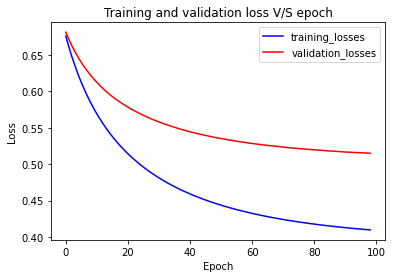

In [83]:
%%time
w, t, v = train_and_evaluate(train_data, train_labels, val_data, val_labels, test_data, test_labels, best_lr, best_alpha, 100)
plot_learning_process(t, v)



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.78  | 0.85  |  0.81 |
| BOW-tfidf  |  0.80 | 0.89  | 0.84  |
| BOCN-count  |  0.56 | 0.97  | 0.71  |
| BOCN-tfidf  |0.60   |  0.70 | 0.64  |
| BOW+BOCN  | 0.80  |  0.86 | 0.83  |

Please discuss why your best performing model is better than the rest.

#### Conclusion 
As it can be concluded from the table, two models give the best F1-scores i.e. "BOW-tfidf" and "BOW+BOCN". So these two models perform better than the rest. The other metrics for the two systems are almost comparable. 
These models perform better than the other two because they both use tfidf weighting schemes. Tf.idf weighting scheme penalize the more frequenct words hence, giving less scores to the common words. So, the model is performing better because it is giving more importance to the context of the words. 